In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import math
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score
import json
import seaborn as sns
import itertools

In [ ]:
from google.colab import drive # Model was trained in google colab
drive.mount('/content/drive') # Mounting the dataset from Google Drive to the Colab

Mounted at /content/drive


In [ ]:
# Loading the dataset
DATA_DIR = '/content/drive/MyDrive/ISproject/Garbage_classification'

"""
The dataset used for training comprises of a combination of images from these two datasets:
 - Garbage Classification (https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification)
 - Waste Classification Data V2 (https://www.kaggle.com/datasets/sapal6/waste-classification-data-v2) 


"""
#Using Keras API from tensorflow to preprocess the dataset and resize them into 256x256 dimensions
train_data = tf.keras.preprocessing.image_dataset_from_directory(DATA_DIR,validation_split=0.2,seed=42,subset="training",smart_resize=True,image_size=(256,256)) # 80/20 train-test split

test_data = tf.keras.preprocessing.image_dataset_from_directory(DATA_DIR,validation_split=0.2,seed=42,subset="validation",smart_resize=True,image_size=(256,256))


# Approximately a 80/20 split

Found 3115 files belonging to 7 classes.
Using 2492 files for training.
Found 3115 files belonging to 7 classes.
Using 623 files for validation.


In [ ]:
class_name = train_data.class_names
numClasses = len(class_name) # 7 classes
print(class_name) # ['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']

['cardboard', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']


In [ ]:
# Creating the model

baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses) # Pulling a pre-trained model from Keras to put on top of our own layers
for layers in baseModel.layers[:-6]: # Might change the model later
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x) # Using softmax as an activation function since it specializes in multiple class classification

model = tf.keras.Model(inputs=baseModel.input,outputs=x)

12683000/12683000 [==============================] - 1s 0us/step


In [ ]:
# Training and testing the model
epochs = 60
learn_rate = 0.0025

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(train_data, validation_data=test_data, epochs=epochs) # Takes approximately 2 hours to train using the default machine of google colab

Epoch 1/60
78/78 [==============================] - 633s 8s/step - loss: 29.0413 - accuracy: 0.7588 - val_loss: 6.9113 - val_accuracy: 0.7143
Epoch 2/60
78/78 [==============================] - 143s 2s/step - loss: 6.7115 - accuracy: 0.7881 - val_loss: 6.7344 - val_accuracy: 0.7255
Epoch 3/60
78/78 [==============================] - 138s 2s/step - loss: 6.8235 - accuracy: 0.8238 - val_loss: 7.0497 - val_accuracy: 0.7191
Epoch 4/60
78/78 [==============================] - 144s 2s/step - loss: 6.7756 - accuracy: 0.8567 - val_loss: 7.3932 - val_accuracy: 0.7255
Epoch 5/60
78/78 [==============================] - 140s 2s/step - loss: 6.7578 - accuracy: 0.8732 - val_loss: 7.0502 - val_accuracy: 0.8218
Epoch 6/60
78/78 [==============================] - 141s 2s/step - loss: 6.7577 - accuracy: 0.8880 - val_loss: 6.5825 - val_accuracy: 0.8202
Epoch 7/60
78/78 [==============================] - 141s 2s/step - loss: 6.4929 - accuracy: 0.9017 - val_loss: 6.7074 - val_accuracy: 0.7978
Epoch 8/60
7

In [ ]:
# Saving the model and its history into files

model.save('/content/model/model.h5')
with open('/content/model/history.json','w') as h:
  json.dump(history.history, h)


In [ ]:
# Run cell to load the model using files

# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/ISproject/model/model.h5')

# Load the history
with open('/content/drive/MyDrive/ISproject/model/history.json', 'r') as h:
    history = json.load(h)

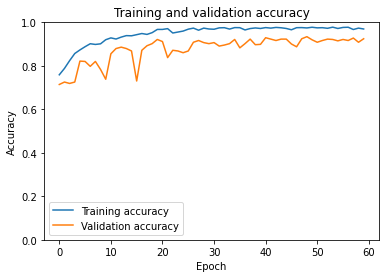

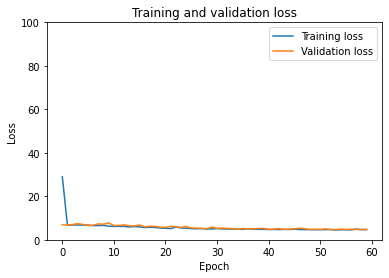

In [ ]:
# Graphing the accuracy and loss of the training and testing datasets

# Extract the training and validation accuracy and loss values from the history object
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

# Plot the training and validation accuracy
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.ylim([0, 1])
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.ylim([0,100])
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Confusion matrix


prediction = np.array([])
true_val =  np.array([])
for x, y in test_data: # Getting predicted and true values of the test data and putting it into a numpy array
  prediction = np.concatenate([prediction, np.argmax(model.predict(x), axis = -1)])
  true_val = np.concatenate([true_val, y])

# Computing the confusion matrix
conf_mat = tf.math.confusion_matrix(labels=true_val, predictions=prediction).numpy()





1/1 [==============================] - 2s 2s/step


Text(0, 0.5, 'True label')

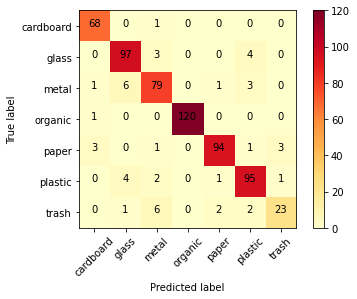

In [ ]:
# Plotting the computed confusion matrix
plt.imshow(conf_mat, cmap='YlOrRd', interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name, rotation=45)
plt.yticks(tick_marks, class_name)
for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        plt.text(j, i, "{:,}".format(conf_mat[i, j]),
                  horizontalalignment="center",
                  color="black")
plt.xlabel('Predicted label')
plt.ylabel('True label')

In [ ]:
# Calculating the F1-score of the model

# Calculate precision and recall 
precision = precision_score(true_val,prediction,average=None) # Precision of each individual class
precision_dict = {}

precision_avg = precision_score(true_val,prediction,average='macro') # Average precision of all classes


recall = recall_score(true_val,prediction,average=None) # Recall of each individual class
recall_dict = {}
recall_avg = recall_score(true_val,prediction,average='macro') # Average recall of all classes


f1_dict = {}
for i in range(len(precision)): # Filling the dictionaries
  precision_dict[class_name[i]] = precision[i]
  recall_dict[class_name[i]] = recall[i]
  f1_dict[class_name[i]] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) # Calculating f1 score per class

# Calculate F1 score average
f1 = 2 * (precision_avg * recall_avg) / (precision_avg + recall_avg)

print(f"Model precision : {precision_dict}")
print(f"Model precision (average of all classes): {precision_avg}\n")
print(f"Model recall : {recall_dict}")
print(f"Model recall (average of all classes): {recall_avg}\n")
print(f"Model F1-score : {f1_dict}")
print(f"Model F1-score (average of all classes): {f1}")

Model precision : {'cardboard': 0.9315068493150684, 'glass': 0.8981481481481481, 'metal': 0.8586956521739131, 'organic': 1.0, 'paper': 0.9591836734693877, 'plastic': 0.9047619047619048, 'trash': 0.8518518518518519}
Model precision (average of all classes): 0.9148782971028965

Model recall : {'cardboard': 0.9855072463768116, 'glass': 0.9326923076923077, 'metal': 0.8777777777777778, 'organic': 0.9917355371900827, 'paper': 0.9215686274509803, 'plastic': 0.9223300970873787, 'trash': 0.6764705882352942}
Model recall (average of all classes): 0.9011545974015192

Model F1-score : {'cardboard': 0.9577464788732394, 'glass': 0.9150943396226415, 'metal': 0.868131868131868, 'organic': 0.995850622406639, 'paper': 0.9400000000000001, 'plastic': 0.9134615384615385, 'trash': 0.7540983606557378}
Model F1-score (average of all classes): 0.9079645924829292


In [ ]:
# Model's Prediction using other pieces of waste as example
# Will add this with the picture of waste such as water bottle.
path = '/content/cardboard2.jpg'
img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

max_index = np.argmax(predictions[0])
print(f"Prediction: {class_name[max_index]} ({max(predictions[0]*100)}%)")

1/1 [==============================] - 0s 46ms/step
Prediction: cardboard (93.96062469482422%)


In [ ]:
# Model's Prediction using other pieces of waste as example
# Will add this with the picture of waste such as water bottle.
path = '/content/bottle.jpeg'
img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

max_index = np.argmax(predictions[0])
print(f"Prediction: {class_name[max_index]} ({max(predictions[0]*100)}%)")

1/1 [==============================] - 0s 67ms/step
Prediction: plastic (94.33612823486328%)


In [ ]:
path = '/content/tebs.jpeg'
img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)

max_index = np.argmax(predictions[0])
print(f"Prediction: {class_name[max_index]} ({max(predictions[0]*100)}%)")

1/1 [==============================] - 0s 73ms/step
Prediction: cardboard (51.66453552246094%)
